In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [26]:
seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)
rng = torch.Generator().manual_seed(seed)

# Load MNIST dataset
mnist = fetch_openml("mnist_784", version=1, parser="pandas")
X = mnist.data.astype(np.float32)   # 28*28 = 784 columns
y = mnist.target.astype(int)

# Train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=20000, stratify=y, random_state=seed)

# Smaller train subset for speed
X_train, _, y_train, _ = train_test_split(
    X_train_full, y_train_full, train_size=20000, stratify=y_train_full, random_state=seed)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train.values)
y_train_t = torch.tensor(y_train.values)
X_test_t = torch.tensor(X_test.values)
y_test_t = torch.tensor(y_test.values)

# Dataloaders
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, generator=rng)
test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False)

In [28]:
# Define MLP Architecture
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)
        self._init_params()

    def _init_params(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  #returns raw logits

# Instantiate models
mlp_model = SimpleMLP()
mlp_untrained = SimpleMLP()

In [29]:
# Training loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-3)

def train(model, loader, epochs=100):
    model.train()
    for ep in range(epochs):
        total_loss = 0
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

train(mlp_model, train_loader, epochs=100)

In [30]:
# Evaluate on test set
mlp_model.eval()
with torch.no_grad():
    logits = mlp_model(X_test_t)
    preds_mlp = logits.argmax(dim=1).numpy()  # predictions

In [31]:
# Compare with Random Forest and Logistic Regression
rf_clf = RandomForestClassifier(n_estimators=100, random_state=seed)
rf_clf.fit(X_train, y_train)
preds_rf = rf_clf.predict(X_test)

lr_clf = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1, random_state=seed)
lr_clf.fit(X_train, y_train)
preds_lr = lr_clf.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [32]:
# Compute Accuracy
acc_mlp = accuracy_score(y_test, preds_mlp)
acc_rf = accuracy_score(y_test, preds_rf)
acc_lr = accuracy_score(y_test, preds_lr)

print(f"Accuracy (MLP): {acc_mlp:.4f}")
print(f"Accuracy (Random Forest): {acc_rf:.4f}")
print(f"Accuracy (Logistic Regression): {acc_lr:.4f}")

Accuracy (MLP): 0.9274
Accuracy (Random Forest): 0.9585
Accuracy (Logistic Regression): 0.8992


In [33]:
# Compute F1-scores
f1_mlp = f1_score(y_test, preds_mlp, average='macro')
f1_rf = f1_score(y_test, preds_rf, average='macro')
f1_lr = f1_score(y_test, preds_lr, average='macro')

print(f"\nF1-score (MLP): {f1_mlp:.4f}")
print(f"F1-score (Random Forest): {f1_rf:.4f}")
print(f"F1-score (Logistic Regression): {f1_lr:.4f}")


F1-score (MLP): 0.9264
F1-score (Random Forest): 0.9582
F1-score (Logistic Regression): 0.8976


Performance hierarchy: Random Forest > MLP > Logistic Regression.

Random Forest Classifier achieved the highest accuracy. Despite the MLP's non-linear capabilities, the Random Forest is more robust and effective at creating complex, non-linear decision boundaries using raw pixel data, especially when the MLP's architecture is constrained to be small (30-20 neurons) and the training data is limited (20,000 images) and less training time (100 epochs).

MLP performs significantly better than Logistic Regression, demonstrating that it successfully learned non-linear relationships, but it couldn't fully compensate for its limited capacity and data size relative to the Random Forest.


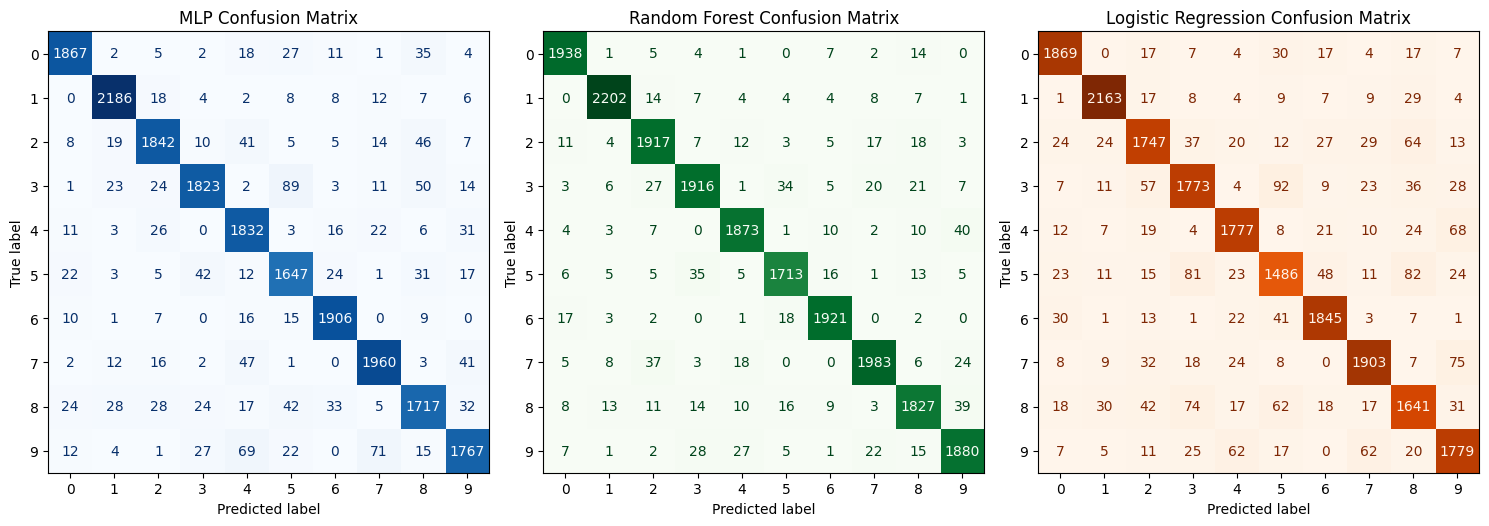

In [35]:
# Confusion Matrices
cm_mlp = confusion_matrix(y_test, preds_mlp)
cm_rf = confusion_matrix(y_test, preds_rf)
cm_lr = confusion_matrix(y_test, preds_lr)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ConfusionMatrixDisplay(cm_mlp).plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("MLP Confusion Matrix")

ConfusionMatrixDisplay(cm_rf).plot(ax=axes[1], cmap='Greens', colorbar=False)
axes[1].set_title("Random Forest Confusion Matrix")

ConfusionMatrixDisplay(cm_lr).plot(ax=axes[2], cmap='Oranges', colorbar=False)
axes[2].set_title("Logistic Regression Confusion Matrix")

plt.tight_layout()
plt.show()

MLP Errors: The MLP shows high confusion between digits with similar structures. The most frequent errors involve predicting '5' instead of '3' (89 instances), '7' instead of '9' (71 instances), and '4' instead of '9' (69 instances).

Random Forest Errors: Random Forest's errors are far lower across the board, it predicts '5' instead of '3' (only 34 instances), '7' instead of '9' (only 22 instances), and '4' instead of '9' (only 27 instances). highest is 9 instead of 4 (40 instances only).

Logistic Regression: predicts '5' instead of '3' (92 instances), '7' instead of '9' (62 instances), and '4' instead of '9' (62 instances). whereas 3 instead of 5 (81 instances), 8 instead of 5 (82 instances) which is worse.

In [36]:
# Extract 20-neuron layer activations
def extract_features(model, loader):
    model.eval()
    feats, lbls = [], []
    with torch.no_grad():
        for xb, yb in loader:
            x = xb.view(-1, 28 * 28)
            h1 = torch.relu(model.fc1(x))
            h2 = torch.relu(model.fc2(h1))
            feats.append(h2)
            lbls.append(yb)
    return torch.cat(feats).numpy(), torch.cat(lbls).numpy()

# Get feature representations
trained_feats, trained_lbls = extract_features(mlp_model, test_loader)
untrained_feats, untrained_lbls = extract_features(mlp_untrained, test_loader)

# Use subset for faster t-SNE
subset = np.random.choice(len(trained_feats), size=2000, replace=False)
trained_subset, trained_lbl_subset = trained_feats[subset], trained_lbls[subset]

subset_un = np.random.choice(len(untrained_feats), size=2000, replace=False)
untrained_subset, untrained_lbl_subset = untrained_feats[subset_un], untrained_lbls[subset_un]

In [37]:
# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=750, random_state=seed)
trained_emb = tsne.fit_transform(trained_subset)
untrained_emb = tsne.fit_transform(untrained_subset)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


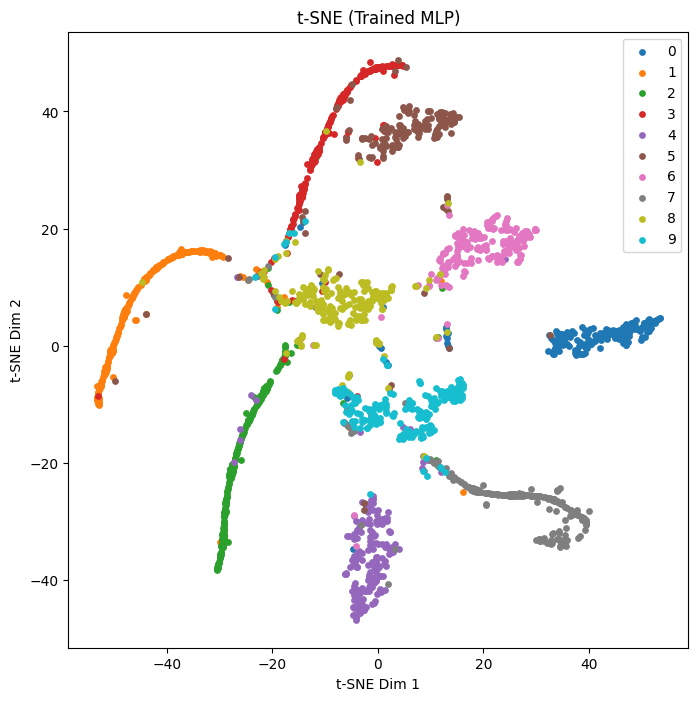

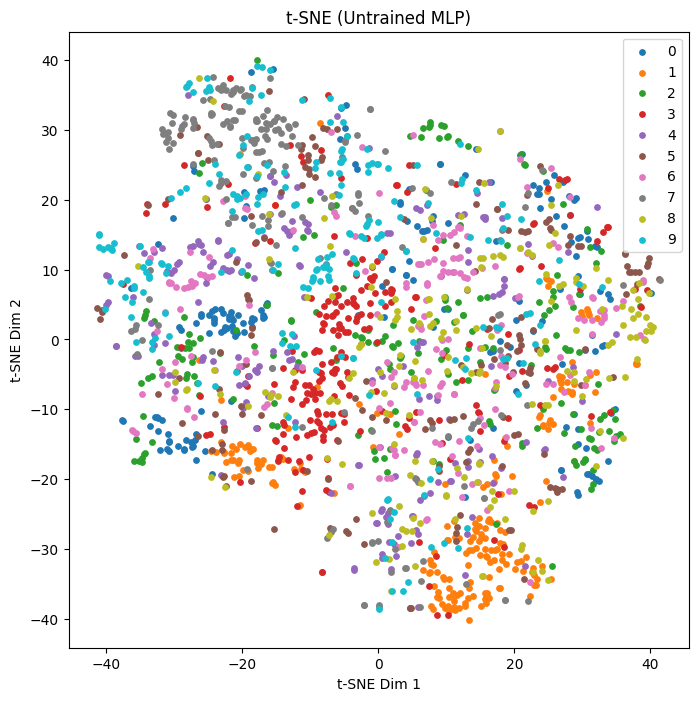

In [38]:
# Plots
def plot_tsne(embeddings, labels, title):
    plt.figure(figsize=(8, 8))
    for digit in range(10):
        mask = labels == digit
        plt.scatter(embeddings[mask, 0], embeddings[mask, 1], s=15, label=str(digit))
    plt.legend()
    plt.title(title)
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.show()

plot_tsne(trained_emb, trained_lbl_subset, "t-SNE (Trained MLP)")
plot_tsne(untrained_emb, untrained_lbl_subset, "t-SNE (Untrained MLP)")

Trained MLP: we can observe clear and better clustering. The points form 10 distinct, well separated clusters each corresponding to a digit. Training successfully learns a feature space where inputs from the same class are mapped close together. There is a very little overlap in regions, but most of the digits are clearly separable. This can be due to the misclassified digits which have similarly written digits.

Untrained MLP: we can just observe a random scatter. Data points for all 10 classes are thoroughly mixed, forming a dense cloud. The lack of clear clusters on the plot means the model can't tell the difference between the digits, which is expected from an untrained system.

In [39]:
# Load Fashion-MNIST
def fetch_dataset(name="Fashion-MNIST", test_size=10000, seed=seed):
    data = fetch_openml(name, version=1, parser="pandas")
    X = data.data.astype(np.float32)
    y = data.target.astype(int)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=seed)
    return X_train, X_test, y_train, y_test

X_fash_train, X_fash_test, y_fash_train, y_fash_test = fetch_dataset("Fashion-MNIST")
X_fash_test_t = torch.tensor(X_fash_test.values, dtype=torch.float32)
y_fash_test_t = torch.tensor(y_fash_test.values, dtype=torch.long)
fash_test_ds = TensorDataset(X_fash_test_t, y_fash_test_t)
fash_test_loader = DataLoader(fash_test_ds, batch_size=1024, shuffle=False)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


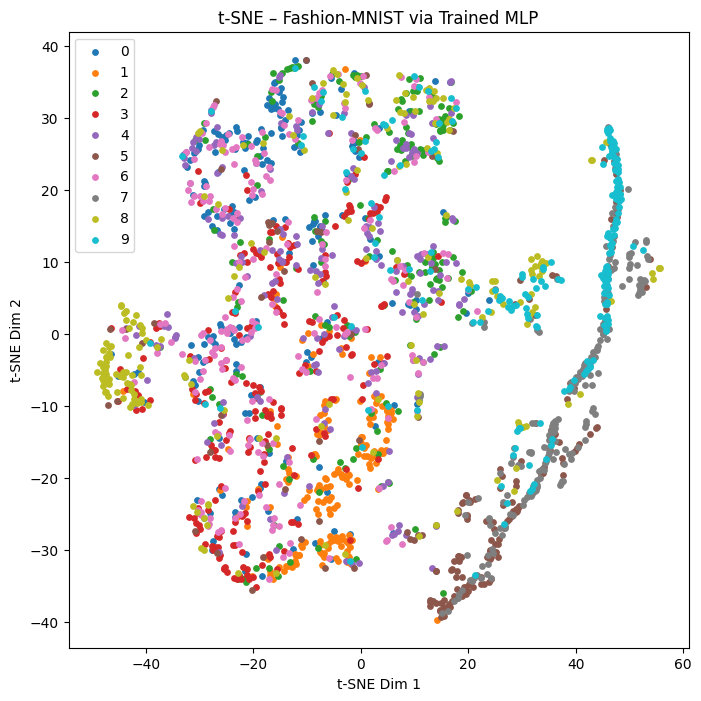

In [40]:
fash_feats, fash_lbls = extract_features(mlp_model, fash_test_loader)

# Run t-SNE on Fashion-MNIST embeddings
tsne_fash = TSNE(n_components=2, perplexity=30, n_iter=750, random_state=seed)
fash_emb = tsne_fash.fit_transform(fash_feats[:2000])   # subset for faster visualization

# Plot Fashion-MNIST embeddings
plot_tsne(fash_emb, fash_lbls[:2000], "t-SNE – Fashion-MNIST via Trained MLP")

The plot shows the classes are highly scattered and mixed, with significant overlap between many categories. This is because the feature mapping encoded in the 20-neuron layer is optimized only for separating handwritten digit shapes and cannot classify clothing items, which are much more visually complex compared to digits. When Fashion-MNIST images are passed through this layer, the resultant embeddings are not structured for separation, visually confirming why the model fails to classify the clothing items accurately.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import gc, time

In [16]:
seed = 2025
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# Load MNIST (Grayscale) for Simple CNN
transform_gray = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

train_data = torchvision.datasets.MNIST(root="./data", train=True, transform=transform_gray, download=True)
test_data  = torchvision.datasets.MNIST(root="./data", train=False, transform=transform_gray, download=True)

# Use smaller subset for speed
subset_idx = list(range(2000))
test_subset = Subset(test_data, subset_idx)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_subset, batch_size=128, shuffle=False)

# Load MNIST for pretrained CNNs (RGB + normalization)
transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

test_data_rgb = torchvision.datasets.MNIST(root="./data", train=False, transform=transform_rgb, download=True)
test_subset_rgb = Subset(test_data_rgb, subset_idx)
test_loader_rgb = DataLoader(test_subset_rgb, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.08MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.68MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.44MB/s]


In [18]:
# Define Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1  = nn.Linear(32 * 14 * 14, 128)
        self.fc2  = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv(x))      # (1,28,28) -> (32,28,28)
        x = self.pool(x)                 # -> (32,14,14)
        x = x.view(x.size(0), -1)        # flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn_model = SimpleCNN().to(device)

In [19]:
# Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)

def train_model(model, loader, epochs=3):
    model.train()
    for ep in range(epochs):
        total_loss = 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {ep+1}/{epochs} - Loss: {total_loss/len(loader):.4f}")

print("\nTraining Simple CNN...")
train_model(cnn_model, train_loader, epochs=3)


Training Simple CNN...
Epoch 1/3 - Loss: 0.2188
Epoch 2/3 - Loss: 0.0731
Epoch 3/3 - Loss: 0.0500


In [20]:
# Evaluation Function
def evaluate_model(model, loader):
    model.eval()
    preds_all, labels_all = [], []
    start = time.time()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds = torch.argmax(out, dim=1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(yb.cpu().numpy())
    end = time.time()
    acc = accuracy_score(labels_all, preds_all)
    f1  = f1_score(labels_all, preds_all, average="macro")
    cm  = confusion_matrix(labels_all, preds_all)
    inf_time = end - start
    return acc, f1, cm, inf_time

In [21]:
# Pretrained CNNs (for inference)
pretrained_models = {
    "MobileNetV2": models.mobilenet_v2(weights="DEFAULT"),
    "EfficientNetB0": models.efficientnet_b0(weights="DEFAULT")}

# Replace classifier heads for 10 MNIST classes
for name, model in pretrained_models.items():
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)
    model.to(device)
    model.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 116MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 140MB/s]



Model Comparison: 
SimpleCNN       | Accuracy: 97.30% | F1: 0.972 | Params: 0.80M | Inference time: 0.87s
MobileNetV2     | Accuracy: 10.55% | F1: 0.028 | Params: 2.24M | Inference time: 123.76s
EfficientNetB0  | Accuracy: 9.50% | F1: 0.064 | Params: 4.02M | Inference time: 171.01s


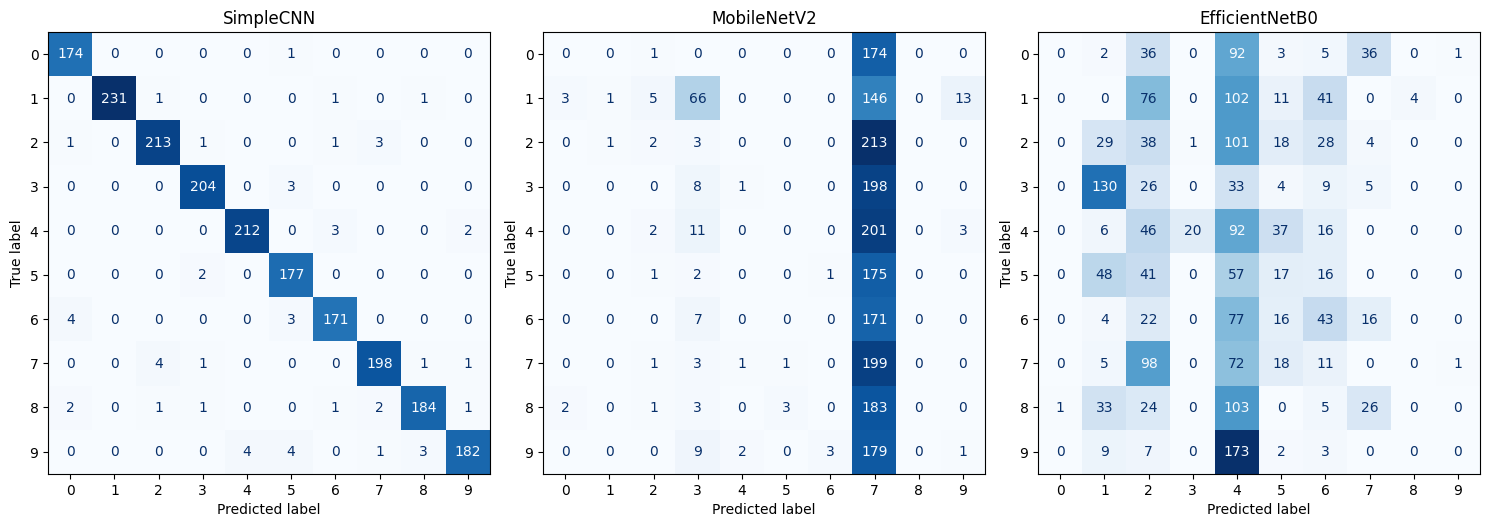

In [22]:
# Evaluate all models
results = {}

acc, f1, cm, t_inf = evaluate_model(cnn_model, test_loader)
results["SimpleCNN"] = (acc, f1, cm, sum(p.numel() for p in cnn_model.parameters()), t_inf)

for name, model in pretrained_models.items():
    acc, f1, cm, t_inf = evaluate_model(model, test_loader_rgb)
    results[name] = (acc, f1, cm, sum(p.numel() for p in model.parameters()), t_inf)
    torch.cuda.empty_cache()
    gc.collect()

print("\nModel Comparison: ")
for name, (acc, f1, cm, params, t_inf) in results.items():
    print(f"{name:15s} | Accuracy: {acc*100:.2f}% | F1: {f1:.3f} | Params: {params/1e6:.2f}M | Inference time: {t_inf:.2f}s")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (name, (acc, f1, cm, params, t_inf)) in enumerate(results.items()):
    ConfusionMatrixDisplay(cm).plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f"{name}")
plt.tight_layout()
plt.show()

In [42]:
def fine_tune_model(model, train_loader, epochs=3, lr=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for ep in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

In [43]:
train_data_rgb = torchvision.datasets.MNIST(root="./data", train=True, transform=transform_rgb, download=True)
subset_idx_train = list(range(2000))
train_subset_rgb = Subset(train_data_rgb, subset_idx_train)
train_loader_rgb = DataLoader(train_subset_rgb, batch_size=64, shuffle=True)

fine_tuned_models = {}

for name, model in pretrained_models.items():
    print(f"\nFine-tuning {name}...")
    # only train last layer for fast computation
    for param in model.features.parameters():
        param.requires_grad = False
    fine_tune_model(model, train_loader_rgb, epochs=3, lr=1e-4)
    fine_tuned_models[name] = model


Fine-tuning MobileNetV2...

Fine-tuning EfficientNetB0...



Model Comparison After Fine-Tuning: 
SimpleCNN            | Accuracy: 97.30% | F1: 0.972 | Params: 0.80M | Inference time: 0.87s
MobileNetV2          | Accuracy: 10.55% | F1: 0.028 | Params: 2.24M | Inference time: 123.76s
EfficientNetB0       | Accuracy: 9.50% | F1: 0.064 | Params: 4.02M | Inference time: 171.01s
MobileNetV2_FineTuned | Accuracy: 96.60% | F1: 0.966 | Params: 2.24M | Inference time: 66.93s
EfficientNetB0_FineTuned | Accuracy: 61.30% | F1: 0.598 | Params: 4.02M | Inference time: 93.60s


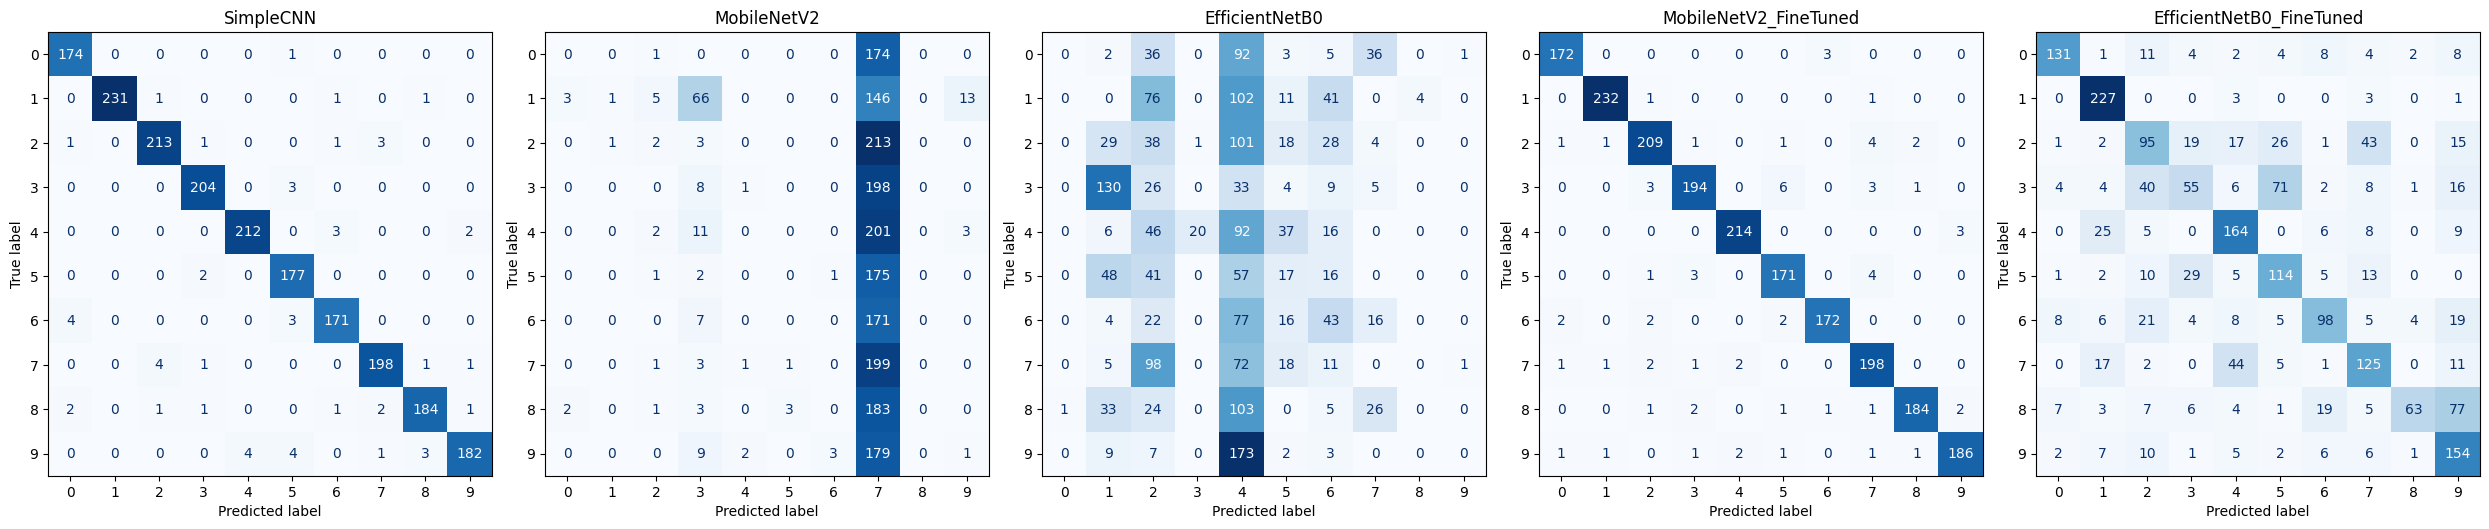

In [44]:
for name, model in fine_tuned_models.items():
    acc, f1, cm, t_inf = evaluate_model(model, test_loader_rgb)
    results[f"{name}_FineTuned"] = (acc, f1, cm, sum(p.numel() for p in model.parameters()), t_inf)
    torch.cuda.empty_cache()
    gc.collect()

print("\nModel Comparison After Fine-Tuning: ")
for name, (acc, f1, cm, params, t_inf) in results.items():
    print(f"{name:20s} | Accuracy: {acc*100:.2f}% | F1: {f1:.3f} | Params: {params/1e6:.2f}M | Inference time: {t_inf:.2f}s")

fig, axes = plt.subplots(1, len(results), figsize=(5*len(results), 5))
for i, (name, (acc, f1, cm, params, t_inf)) in enumerate(results.items()):
    ConfusionMatrixDisplay(cm).plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f"{name}")
plt.tight_layout()
plt.show()

SimpleCNN is the clear winner by comparing all the metrics.

SimpleCNN achieved the highest accuracy and F1-score, also most efficient with fewest parameters and fastest inference time. This demonstrates that for a simple dataset like MNIST, a small and custom-built CNN is often the most effective solution. It has the perfect capacity to capture the necessary features without overfitting.

 It highlights the problem of using oversized, complex architectures for simple problems, that introduce massive computational load with no performance gain.

Both MobileNet and EfficientNet, when used directly for inference on MNIST  performed nearly random 10%. This is expected result of using models pretrained on ImageNet (which is a dataset of real world objects) to classify grayscale handwritten digits since the feature extractors learned from ImageNet are irrelevant to the MNIST domain.

After fine-tuning, MobileNet drastically improved showing that freezing the feature backbone and retraining the classification head, allowed the model to leverage its large capacity while learning the MNIST-specific classification task. EfficientNet also improved significantly but lagged behind, reaching only 61%, problem might be somewhere in the way it was pretrained.

We can observe the performance improvement visibly thorugh the confusion matrices.